In [ ]:
# default_exp utils_trajectories

In [2]:
#export    
import numpy as np    

# Helper functions

### Pert distribution

In [25]:
#export 
def pert(params, size=1, lamb=4):
    if isinstance(params, float) or isinstance(params, int):
        if size == 1:
            return params
        else:
            return np.array(params).repeat(size)
    
    a, b, c = params
    # if all parameters are the same, we consider it a delta distribution
    if a == b == c:
        return np.array([a]*size)
    r = c - a
    alpha = 1 + lamb * (b - a) / r
    beta = 1 + lamb * (c - b) / r
    return a + np.random.beta(alpha, beta, size=size) * r

### Gaussian distribution

In [43]:
#export
import scipy.stats
def gaussian(params, size = 1, bound = None):
    # if we are given a single number, we consider equal to mean and variance = 0
    if isinstance(params, float) or isinstance(params, int):
        if size == 1:
            return params
        else:
            return np.array(params).repeat(size)
    else:
        mean, var = params
        if bound is None:
            val = np.random.normal(mean, np.sqrt(var), size)
        if bound is not None:
            lower, upper = bound
            val = scipy.stats.truncnorm.rvs((lower-mean)/np.sqrt(var),
                                            (upper-mean)/np.sqrt(var),
                                            loc = mean,
                                            scale = np.sqrt(var),
                                            size = size)
        if size == 1:
            return val[0]
        else:
            return val

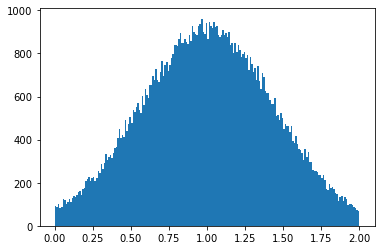

In [41]:
import matplotlib.pyplot as plt
k = gaussian([1, 0.2], size = int(1e5), bound = [0, 2])
plt.hist(k, bins = 200);

## 1D Brownian motion

In [ ]:
#export    
def bm1D(T, D, deltaT = False):
    '''Creates a 1D Brownian motion trajectory'''
    if D < 0:
        raise ValueError('Only positive diffusion coefficients allowed.') 
    if not deltaT:               
        deltaT = 1
    return np.cumsum(np.sqrt(2*D*deltaT)*np.random.randn(int(T)))        
     

## Regularize trajectory with irregular sampling times

In [ ]:
#export    
def regularize(positions, times, T):
    '''Regularizes a trajectory with irregular sampling times.
    Arguments:
        - positions (numpy.array): collections of positions
        - times (numpy.array): collections of sampling times
        - T (int): lenght of the output trajectory
        
        return: numpy.array''' 
    times = np.append(0, times)
    pos_r = np.zeros(T)
    for idx in range(len(times)-1):
        pos_r[int(times[idx]):int(times[idx+1])] = positions[idx]
    pos_r -= pos_r[0]
    return pos_r

## Sampler random points in the surface of a sphere

In [ ]:
#export    
def sample_sphere(N, R):
    '''Samples random number that lay in the surface of a 3D sphere centered in 
    zero and with radius R
    Arguments:
        - N (int): number of points to generate.
        - R (int or numpy.array): radius of the sphere. If int, all points have
        the same radius, if numpy.array, each number has different radius.'''
    vecs = np.random.randn(3, N)
    vecs /= np.linalg.norm(vecs, axis=0)
    return R*vecs

## Normalize displacements of a trajectory

In [ ]:
#export    
def normalize(trajs):    
    ''' Normalizes trajectories by substracting average and dividing by sqrt of msd
    Arguments:
    - traj: trajectory or ensemble of trajectories to normalize. 
    - dimensions: dimension of the trajectory.
        return: normalized trajectory'''
    if len(trajs.shape) == 1:
        trajs = np.reshape(trajs, (1, trajs.shape[0]))
    trajs = trajs - trajs.mean(axis=1, keepdims=True)
    displacements = (trajs[:,1:] - trajs[:,:-1]).copy()    
    variance = np.std(displacements, axis=1)
    variance[variance == 0] = 1    
    new_trajs = np.cumsum((displacements.transpose()/variance).transpose(), axis = 1)
    return np.concatenate((np.zeros((new_trajs.shape[0], 1)), new_trajs), axis = 1)

## Adding noise to trajectories

In [ ]:
#export    
def add_noisy_localization(self, trajs, noise_func = False, sigma = 1, mu = 0):
        
        if isinstance(noise_func, np.ndarray):
            noise_matrix = noise_func 
        elif not noise_func:
            noise_matrix = sigma*np.random.randn(trajs.shape[0], trajs.shape[1])+mu
        elif hasattr(noise_func, '__call__'):
            noise_matrix = noise_func(trajs.shape[0], trajs.shape[1])             
        else:
            raise ValueError('noise_func has to be either False for Gaussian noise, a Python function or numpy array.')
        
        trajs += noise_matrix 
        
        return trajs

In [ ]:
#export    
def add_noisy_diffusion(self, trajs, diffusion_coefficients = False):

    # First normalize the trajectories
    trajs = normalize(trajs)
    # If no new diffusion coefficients given, create new ones randonmly
    if not diffusion_coefficients:
        diffusion_coefficients = np.random.randn(trajs.shape[0])
    # Apply new diffusion coefficients
    trajs = (trajs.transpose()*diffusion_coefficients).transpose()

    return trajs

# Trigonometry functions

Needed for the correct calculation of confined diffusion in circular compartments.

In [12]:
#export
import math

class trigo():
    
    ''' Extracted from 
    https://stackoverflow.com/questions/30844482/what-is-most-efficient-way-to-find-the-intersection-of-a-line-and-a-circle-in-py '''
    def circle_line_segment_intersection(circle_center, circle_radius, pt1, pt2, full_line=False, tangent_tol=1e-9):
        """ Find the points at which a circle intersects a line-segment.  This can happen at 0, 1, or 2 points.
        Args:
        :circle_center: The (x, y) location of the circle center
        :circle_radius: The radius of the circle
        :pt1: The (x, y) location of the first point of the segment
        :pt2: The (x, y) location of the second point of the segment
        :full_line: True to find intersections along full line - not just in the segment.  False will just return intersections within the segment.
        :tangent_tol: Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
        
        return Sequence[Tuple[float, float]]: A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

        Note: We follow: http://mathworld.wolfram.com/Circle-LineIntersection.html
        """

        (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
        (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
        dx, dy = (x2 - x1), (y2 - y1)
        dr = (dx ** 2 + dy ** 2)**.5
        big_d = x1 * y2 - x2 * y1
        discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

        if discriminant < 0:  # No intersection between circle and line
            return []
        else:  # There may be 0, 1, or 2 intersections with the segment
            intersections = [
                (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
                 cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
                for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
            if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
                fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
                intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
            if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
                return [intersections[0]]
            else:
                return intersections
            
    def seg_to_vec(seg):
        ''' Find the vector given a segment created by two 2D points'''
        return [(seg[0][0]-seg[1][0]), (seg[0][1]-seg[1][1])]

    def ang_line(lineA, lineB):
        ''' Calculates the angle between two lines/segments'''
        # Get vector form
        vA = trigo.seg_to_vec(lineA)
        vB = trigo.seg_to_vec(lineB)
        return trigo.ang_vec(vA, vB)

    def ang_vec(vA, vB):
        ''' Calculates the angle between two vectors'''
        # Get dot prod
        dot_prod = np.dot(vA, vB)
        # Get magnitudes
        magA = np.dot(vA, vA)**0.5
        magB = np.dot(vB, vB)**0.5
        # Get cosine value
        cos_ = dot_prod/magA/magB
        # Get angle in radians and then convert to degrees
        return math.acos(dot_prod/magB/magA)    
    
    def rotate_vec(vec, angle):
        return (vec[0]*np.cos(angle) + vec[1]*np.sin(angle), -vec[0]*np.sin(angle) + vec[1]*np.cos(angle))
    

# Adding field of view

In [3]:
#export
def find_nan_segments(a, cutoff_length):    
    ''' Extract all segments of nans bigger than the set cutoff_length. If no segments are found, returns None. 
    For each segments, returns the begining and end index of it.
    
    Output: array of size (number of segments) x 2.
    '''
    mask = np.concatenate(([False],np.isnan(a),[False]))
    if ~mask.any():
        return None
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        seg_length = (idx[1::2] - idx[::2])
        idx_seg_long = np.argwhere(seg_length >= cutoff_length).flatten()
        if idx_seg_long.shape[0] == 0: 
            return None
        else:
            return np.array([idx[::2][idx_seg_long], idx[1::2][idx_seg_long]]).transpose()

In [47]:
#export
def segs_inside_fov(traj, fov_max, fov_min, cutoff_length):
    ''' Given a trajectory, finds the segments inside the field of view (FOV).    
    Outputs: index of of segments inside the FOV or None if no segments fulfill the conditions'''
    
        
    # extract components
    x, y = traj[:, 0].copy(), traj[:, 1].copy()
    
    
    # Interior points to the FOV are set to nans
    x[np.argwhere((x > fov_min) & (x < fov_max))] = np.nan
    y[np.argwhere((y > fov_min) & (y < fov_max))] = np.nan

    # Compare the minimums of each array. This way, if at least one dimension
    # is outside (i.e. not nan), the whole segment will be considered outside
    merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)
    
    # Find nan segments bigger than cutoff_length
    nan_segms = find_nan_segments(merge_dims, cutoff_length = cutoff_length)
    
    return nan_segms
    

In [11]:
#export
def segs_inside_fov(traj, fov_origin, fov_length, cutoff_length):
    ''' Given a trajectory, finds the segments inside the field of view (FOV).   
    Args:
    :traj (array): set of trajectories of size N x T (N: number trajectories, T: length)
    :fov_origin (tuple): bottom right point of the square defining the FOV
    :fov_length (scalar): size of the box defining the FOV
    :cutoff_length (scalar): minimum length of a trajectory inside the FOV to be considered 
                             in the output dataset
    Return
    :segs_fov: set of segments inside the FOV'''
    
    fov_min_x, fov_min_y = fov_origin
    fov_max_x, fov_max_y = np.array(fov_origin)+fov_length
        
    # extract components
    x, y = traj[:, 0].copy(), traj[:, 1].copy()
    
    
    # Interior points to the FOV are set to nans
    x[np.argwhere((x > fov_min_x) & (x < fov_max_x))] = np.nan
    y[np.argwhere((y > fov_min_y) & (y < fov_max_y))] = np.nan

    # Compare the minimums of each array. This way, if at least one dimension
    # is outside (i.e. not nan), the whole segment will be considered outside
    merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)
    
    # Find nan segments bigger than cutoff_length
    nan_segms = find_nan_segments(merge_dims, cutoff_length = cutoff_length)
    
    return nan_segms
    

In [5]:
from andi_datasets.models_phenom import models_phenom

L = 200; T = 1000
Ns = [20,10,10]
alphas = [1,1.5]
D = 1   
trajs, labels = [], []
for ns, alpha in zip(Ns, alphas):
    ts, ls = models_phenom().single_state(N = ns,
                                        L = L,
                                        T = T, 
                                        alpha = alpha,
                                        D = D)
    trajs.append(ts)
    labels.append(ls)
    
trajs = np.concatenate(trajs, axis = 1)
labels = np.concatenate(labels, axis = 1)

In [38]:
fov_origin = [20,20]; fov_length = L*0.5
in_seg_x, in_seg_y = [], []
cutoff_length = 10


for idx, og_traj in enumerate(trajs[:, :, :].transpose(1,0,2)):
    nan_segms = segs_inside_fov(og_traj, fov_origin, fov_length, cutoff_length)
    
    if nan_segms is not None:
        for idx_nan in nan_segms:            
            in_seg_x.append(og_traj[idx_nan[0]:idx_nan[1], 0])
            in_seg_y.append(og_traj[idx_nan[0]:idx_nan[1], 1]) 
 

<ipython-input-11-21675371dfdd>:26: RuntimeWarning: All-NaN slice encountered
  merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)


[Text(0.5, 0, 'X (px)'), Text(0, 0.5, 'Y (px)')]

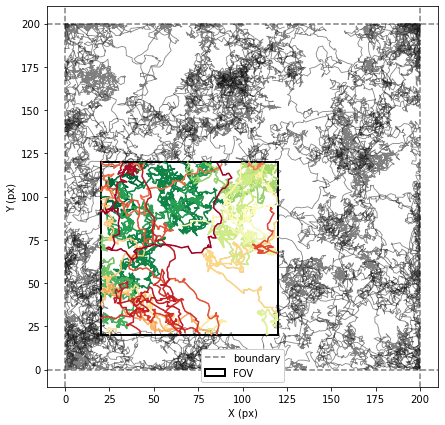

In [40]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (7,7))

colors = plt.cm.RdYlGn(np.linspace(0, 1, len(in_seg_x)))


for idx, og_traj in enumerate(trajs[:, :, :].transpose(1,0,2)):
    ax.plot(og_traj[:, 0], og_traj[:, 1], c = 'k', alpha = 0.5, lw = 0.8)

for x, y, c in zip(in_seg_x, in_seg_y, colors[::-1, :]):
    ax.plot(x, y, c= c)


# FOV
fov_min_x, fov_min_y = fov_origin
fov_max_x, fov_max_y = np.array(fov_origin)+fov_length
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((fov_min_x, fov_min_y), fov_length, fov_length, fill=None, alpha=1, lw = 2, label = 'FOV'))

# plt.plot([fov_])
# ax.axhline(fov_min_x,  c = 'k', label = 'FOV')
# ax.axhline(fov_min_y,  c = 'k')
# ax.axvline(fov_min_x,  c = 'k')
# ax.axvline(fov_min_y,  c = 'k')

# Boundary
ax.axhline(0,  alpha = 0.5, ls = '--', c = 'k', label = 'boundary')
ax.axhline(L,  alpha = 0.5, ls = '--', c = 'k')
ax.axvline(0,  alpha = 0.5, ls = '--', c = 'k')
ax.axvline(L,  alpha = 0.5, ls = '--', c = 'k')

legend = ax.legend()
legend.get_frame().set_alpha(None)
plt.setp(ax, xlabel = 'X (px)', ylabel = 'Y (px)')

# Plotting trajectories

In [52]:
# export
import matplotlib.pyplot as plt

def plot_trajs(trajs, L , N, 
               num_to_plot = 3,
               labels = None,
               plot_labels = False,
               traps_positions = None,
               comp_center = None, r_cercle = None
              ):
    
    if plot_labels:
        fig, axs = plt.subplots(3, num_to_plot, figsize = (num_to_plot*4, 3*3), tight_layout = True)
    else:
        fig, axs = plt.subplots(2, num_to_plot, figsize = (num_to_plot*4, 2*3), tight_layout = True)

    for ax in axs.transpose():
        
        if traps_positions is not None:
            ax[0].scatter(traps_positions[:,0], traps_positions[:,1], c = 'C1')
            
        if comp_center is not None:
            for c in comp_center:
                circle = plt.Circle((c[0], c[1]), r_cercle, facecolor = 'None', edgecolor = 'C1', zorder = 10)
                ax[0].add_patch(circle) 

        
        part = np.random.randint(N)    
        ax[0].set_title(f'Particle # {part}')
        ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.8)
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k', label = 'Boundary')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')

        ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
        ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        
        if plot_labels:
            ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
            ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


    plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')
    axs[0, 0].legend()
    axs[1, 0].legend()
    plt.setp(axs[1, 0], ylabel = 'Position')
    plt.setp(axs[1, :], xticklabels = '')
   
    if plot_labels:
        axs[2, 0].legend()
        plt.setp(axs[2, 0], ylabel = 'Labels')
        plt.setp(axs[2, :], xlabel = 'Time');
    else:
        plt.setp(axs[1, :], xlabel = 'Time');
        

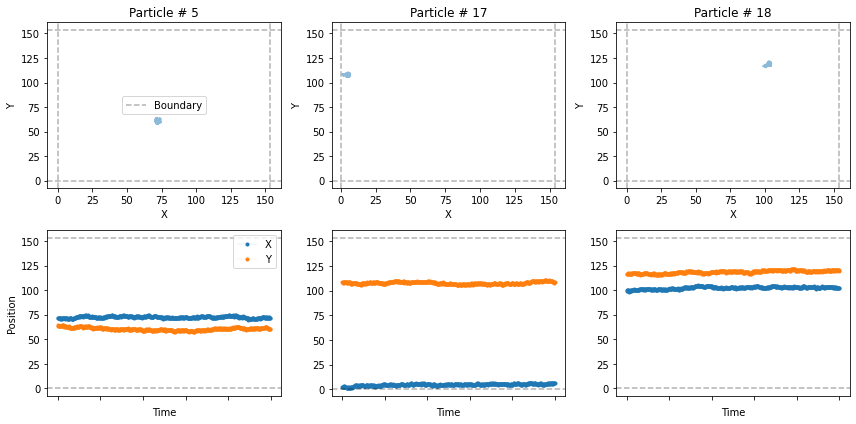

In [48]:
from andi_datasets.models_phenom import models_phenom
T = 500; N = 50; L = 1.2*128; D = 0.1

trajs_model1, labels = models_phenom().single_state(N = N, 
                                            L = L,
                                            T = T,
                                            D = D,
                                            alpha = 0.5
                                            )

plot_trajs(trajs_model1, L, N)

# nbdev

In [41]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
